In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==2.3.1  # 2.4 was being buggy so I downgraded to 2.3.1
!apt-get install openslide-tools
!pip install openslide-python

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import time
import gc

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

In [5]:
tf.__version__

'2.3.1'

In [6]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [7]:
# This will get all the associated zoom levels for each coordinate box
# each coordinate starts with the zoom level but then each level gets its own box
# we will only take images that are at least 50% tissue 
# a box is determined to contain a tumor if .5% of the box is tumorous
def getGridImages(slide, mask, levels, img_size):
  slides, y_out, slide_coords = [[] for level in levels], [], []

  coord_boxes = []
  max_width = slide.level_dimensions[0][0]
  max_height = slide.level_dimensions[0][1]
  for x in range(0, max_width-299, 299*(2**levels[0])):
    for y in range(0, max_height-299, 299*(2**(levels[0]))):
      coord_boxes.append([x,y])
  width, height, _ = img_size
  for i, box in enumerate(coord_boxes):
    x, y = box
    slide_img = read_slide(slide, x, y, level=levels[0], width=width, height=height)
    tissue_pixels = find_tissue_pixels(slide_img)
    percent_tissue = len(tissue_pixels) / float(slide_img.shape[0]*slide_img.shape[1])
    if percent_tissue < .5:
      continue
    mask_img = read_slide(mask, x, y, level=levels[0], width=width, height=height)
    mask_img = mask_img[:,:,0]
    if mask_img.sum() > 0:
      y_out.append(1)
    else:
      y_out.append(0)
    for i, level in enumerate(levels):
      slide_img = read_slide(slide, x, y, level=level, width=width, height=height)
      slide_img = slide_img.astype(float)
      slide_img /= 255.
      slides[i].append(slide_img)
    slide_coords.append((x, y, width, height, levels[0]))

  return np.asarray(slides), np.asarray(y_out), slide_coords
      

In [8]:
# Multichannel model, all we need to do is pick the number of levels and each
# level will have a InceptionV3 model generated from it
# We are not finetuning the inceptionV3 instead we just train a new dense layer
def multichannel_model(levels):
  model = {}
  for i, level in enumerate(levels):
    model[level] = {}
    model[level]['inception'] = InceptionV3(include_top=False, weights='imagenet')
    model[level]['inception']._name = model[level]['inception']._name + f"_{i}"
    for layer in model[level]['inception'].layers:
      layer.trainable = False
      layer._name = layer._name + f"_{i}"
    model[level]['x'] = model[level]['inception']
    model[level]['pool'] = GlobalAveragePooling2D()(model[level]['x'].output)
  merged = concatenate([model[level]['pool'] for level in model])
  dense = Dense(128, activation='relu')(merged)
  output = Dense(1, activation='sigmoid')(dense)
    
  return Model(inputs=[model[level]['x'].input for level in model], outputs=output)

In [9]:
# Create the model with the desired number of levels
# 3 levels is too much in memory and we get a good enough result with 2 levels
# We choose the lowest zoom levels that fit in memory
levels = [3,4]
model = multichannel_model(levels)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=BinaryAccuracy(threshold=.1))


In [ ]:
model.summary()

In [11]:
# Get the images for training from google drive
np.random.seed(714)
path = "drive/MyDrive/dl_final_project/slides/"
data_files = os.listdir(path)
# because I am training on a subset I manually chose the test set ahead of time
# to make sure the items will be informative to test on 
mask_files = [file for file in data_files if '_mask.tif' in file and
              '031' not in file and '016' not in file and '023' not in file]

pairs = [(mask[:9]+'.tif', mask) for mask in mask_files if mask[:9]+'.tif' in data_files]
np.random.shuffle(pairs)
train_pairs = pairs[:7]
val_pairs = pairs[7:10]

In [12]:
used_slides_path = "drive/MyDrive/dl_final_project/used_slides/"

In [13]:
first = True
for slide_path, mask_path in train_pairs:
  print(slide_path)
  print(mask_path)
  slide= open_slide(used_slides_path+slide_path)
  mask = open_slide(used_slides_path+mask_path)
  if first:
    X_train, Y_train, _ = getGridImages(slide, mask, levels=levels, 
                                     img_size=(299, 299, 3))
    first = False
  else:
    new_X, new_Y, _ = getGridImages(slide, mask, levels=levels, 
                                     img_size=(299, 299, 3))
    X_train = np.append(X_train, new_X, axis=1)
    Y_train = np.append(Y_train, new_Y)

print(X_train.shape)
print(len(Y_train), Y_train.sum())

tumor_110.tif
tumor_110_mask.tif
tumor_081.tif
tumor_081_mask.tif
tumor_001.tif
tumor_001_mask.tif
tumor_064.tif
tumor_064_mask.tif
tumor_094.tif
tumor_094_mask.tif
tumor_012.tif
tumor_012_mask.tif
tumor_101.tif
tumor_101_mask.tif
(2, 1876, 299, 299, 3)
1876 377


In [14]:
first = True
for slide_path, mask_path in val_pairs:
  print(slide_path)
  print(mask_path)
  slide = open_slide(used_slides_path+slide_path)
  mask = open_slide(used_slides_path+mask_path)
  if first:
    X_val, Y_val, _ = getGridImages(slide, mask, levels=levels, 
                                     img_size=(299, 299, 3))
    first = False
  else:
    new_X, new_Y, _ = getGridImages(slide, mask, levels=levels, 
                                     img_size=(299, 299, 3))
    X_val = np.append(X_val, new_X, axis=1)
    Y_val = np.append(Y_val, new_Y)

print(X_val.shape)
print(len(Y_val), Y_val.sum())

tumor_005.tif
tumor_005_mask.tif
tumor_075.tif
tumor_075_mask.tif
tumor_059.tif
tumor_059_mask.tif
(2, 438, 299, 299, 3)
438 22


In [15]:
# get variables ready to be inputted
train_input = [X_train[i] for i in range(len(X_train))]
val_input = [X_val[i] for i in range(len(X_val))]

In [16]:
# free up memory so we don't crash colab
del X_train, X_val, new_X, new_Y
gc.collect()

106

In [17]:
filepath = 'multichannel_inception_best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=0, save_best_only=True, mode='max')
history = model.fit(train_input, Y_train, epochs=10, batch_size=16, shuffle=True,
          validation_data=(val_input, Y_val), callbacks=[checkpoint])
model = load_model('multichannel_inception_best_model.h5')

Epoch 1/10
118/118 [==============================] - 19s 162ms/step - loss: 0.2773 - binary_accuracy: 0.7569 - val_loss: 0.2310 - val_binary_accuracy: 0.7100
Epoch 2/10
118/118 [==============================] - 15s 124ms/step - loss: 0.1598 - binary_accuracy: 0.8689 - val_loss: 0.2953 - val_binary_accuracy: 0.9384
Epoch 3/10
118/118 [==============================] - 13s 112ms/step - loss: 0.1440 - binary_accuracy: 0.8854 - val_loss: 0.2411 - val_binary_accuracy: 0.8196
Epoch 4/10
118/118 [==============================] - 13s 112ms/step - loss: 0.1102 - binary_accuracy: 0.9147 - val_loss: 0.3240 - val_binary_accuracy: 0.9247
Epoch 5/10
118/118 [==============================] - 13s 112ms/step - loss: 0.1070 - binary_accuracy: 0.9083 - val_loss: 0.3812 - val_binary_accuracy: 0.9292
Epoch 6/10
118/118 [==============================] - 13s 113ms/step - loss: 0.0729 - binary_accuracy: 0.9328 - val_loss: 0.3791 - val_binary_accuracy: 0.9269
Epoch 7/10
118/118 [==========================

In [18]:
del train_input, val_input, Y_train, Y_val
gc.collect()

50

In [68]:
def predict_mask(slide_path, mask_path, model, level, x, y, width, height, img_size=(299,299,3)):
  slide = open_slide(slide_path)
  mask = open_slide(mask_path)
  slide_image = read_slide(slide, 
                          x=x*(2**level), 
                          y=y*(2**level), 
                          level=level, 
                          width=width, 
                          height=height)
  mask_image = read_slide(mask, 
                        x=x*(2**level), 
                        y=y*(2**level), 
                        level=level, 
                        width=width, 
                        height=height)
  # boxes = []
  # for x_coord in range(0, width, img_size[0]):
  #   for y_coord in range(0, height, img_size[1]):
  #     boxes.append((x_coord, y_coord))
  # mask_box = predict_boxes(boxes, slide, levels, model, width, height)
  slides, y_true, y_coords = getGridImages(slide, mask, levels, (299,299,3))
  input = [i for i in slides]
  y_pred = model.predict(input)
  y_pred = y_pred[:, 0] > .1
  y_pred.astype(int)
  assert len(y_pred) == len(y_coords)
  mask = []
  for i, pred in enumerate(y_pred):
    if pred:
      for x_coord in range(y_coords[i][0]//(2**levels[0]), y_coords[i][0]//(2**levels[0])+299):
        for y_coord in range(y_coords[i][1]//(2**levels[0]), y_coords[i][1]//(2**levels[0])+299):
          mask.append((x_coord-x,y_coord-y))
  pred_mask = apply_mask(slide_image, mask)

  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  plt.title(slide_path.split("/")[-1])
  plt.imshow(np.transpose(pred_mask, axes=(1,0,2)), cmap='jet', alpha=.5)
  plt.imshow(mask_image, cmap='jet', alpha=.5)


In [ ]:
gc.collect()

In [22]:
def predict_score(slide_path, mask_path, model, levels, img_size=(299,299,3)):
  slide = open_slide(slide_path)
  mask = open_slide(mask_path)
  X, Y, _ = getGridImages(slide, mask, levels=levels, 
                                     img_size=img_size)
  X = [i for i in X]
  Y_pred = model.predict(X)
  Y_pred = Y_pred[:, 0] > .1
  Y_pred.astype(int)
  return classification_report(Y, Y_pred)

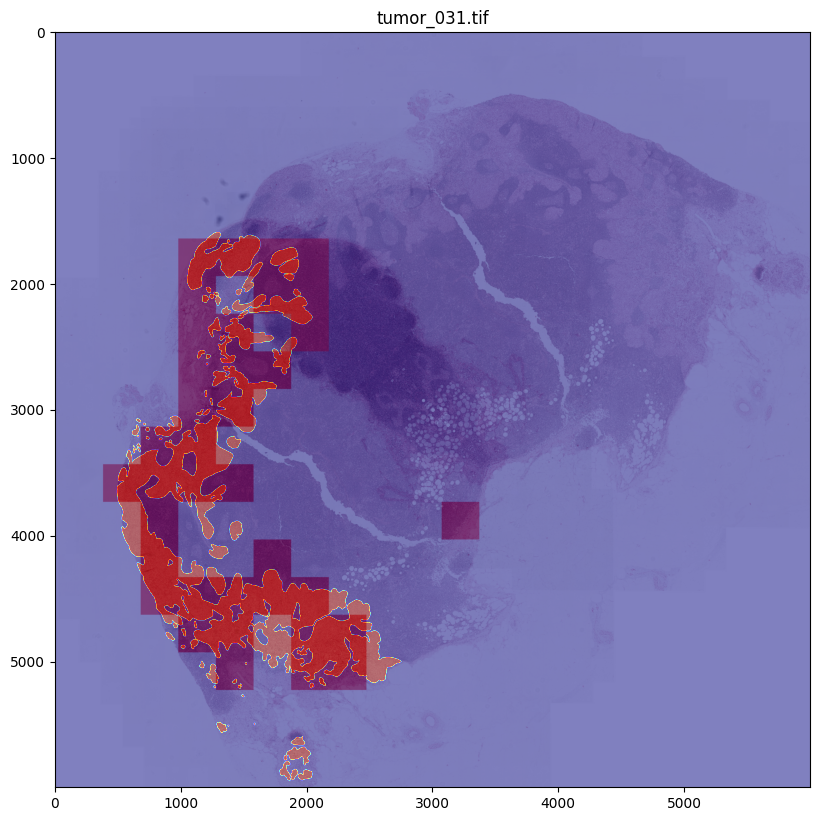

In [48]:
# chosen because there is a large amount of tumor but it is spread out
slide_path = used_slides_path+'tumor_031.tif'
mask_path = used_slides_path+'tumor_031_mask.tif'
predict_mask(slide_path, mask_path, model, levels[0], 5000, 16000, 6000, 6000)

In [73]:
slide_path = used_slides_path+'tumor_031.tif'
mask_path = used_slides_path+'tumor_031_mask.tif'
print(predict_score(slide_path, mask_path, model, levels))

              precision    recall  f1-score   support

           0       0.83      0.99      0.91        87
           1       0.97      0.68      0.80        53

    accuracy                           0.87       140
   macro avg       0.90      0.83      0.85       140
weighted avg       0.89      0.87      0.87       140



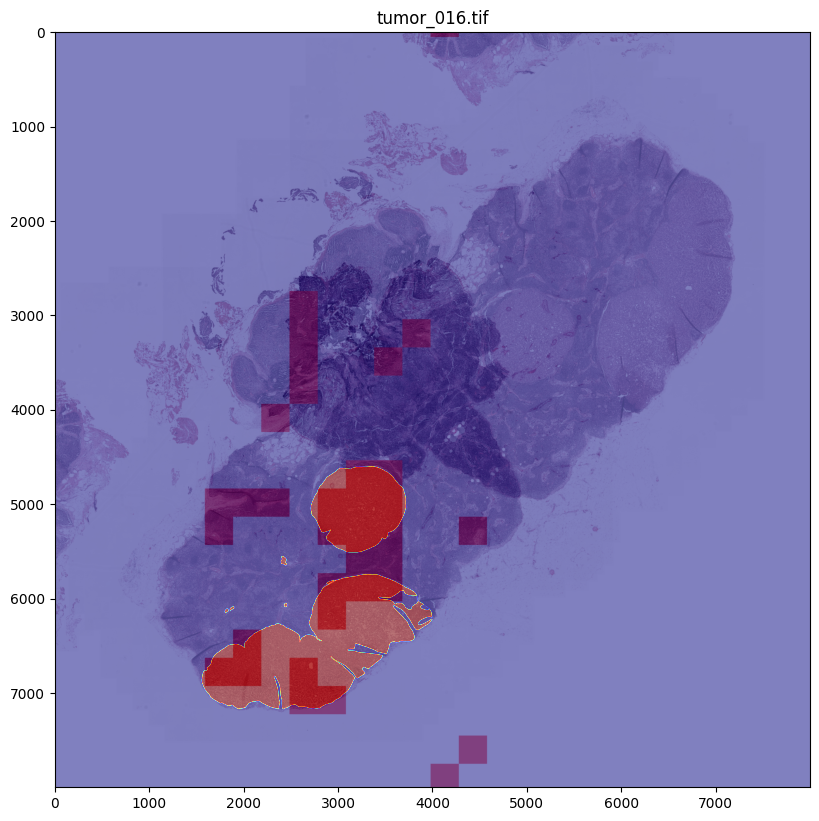

In [69]:
# chosen because there is a large amount of tumor concentrated
slide_path = used_slides_path+'tumor_016.tif'
mask_path = used_slides_path+'tumor_016_mask.tif'
predict_mask(slide_path, mask_path, model, levels[0], 2000, 14000, 8000, 8000)

In [72]:
slide_path = used_slides_path+'tumor_016.tif'
mask_path = used_slides_path+'tumor_016_mask.tif'
print(predict_score(slide_path, mask_path, model, levels))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       156
           1       0.59      0.41      0.48        49

    accuracy                           0.79       205
   macro avg       0.71      0.66      0.68       205
weighted avg       0.77      0.79      0.78       205



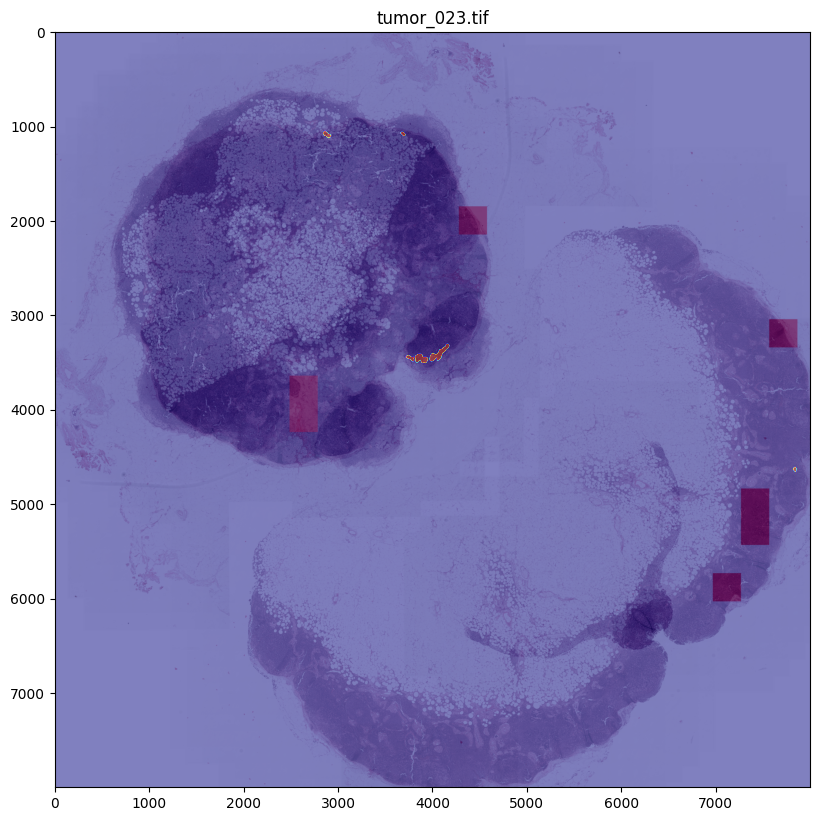

In [70]:
# chosen because there is almost no tumor to be found
slide_path = used_slides_path+'tumor_023.tif'
mask_path = used_slides_path+'tumor_023_mask.tif'
slide = open_slide(slide_path)
predict_mask(slide_path, mask_path, model, levels[0], 2000, 14000, 8000, 8000)

In [71]:
slide_path = used_slides_path+'tumor_023.tif'
mask_path = used_slides_path+'tumor_023_mask.tif'
print(predict_score(slide_path, mask_path, model, levels))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       169
           1       0.00      0.00      0.00         6

    accuracy                           0.93       175
   macro avg       0.48      0.48      0.48       175
weighted avg       0.93      0.93      0.93       175

